Input directory is:  /media/ab/data/Research_Data/GroSeqElongation/
Output directory is:  /media/ab/data/Research_Data/GroSeqElongation/
3726 3726
3559 3559
7285 7285
N =  3681
pearson r =  0.647
p-value =  0.0


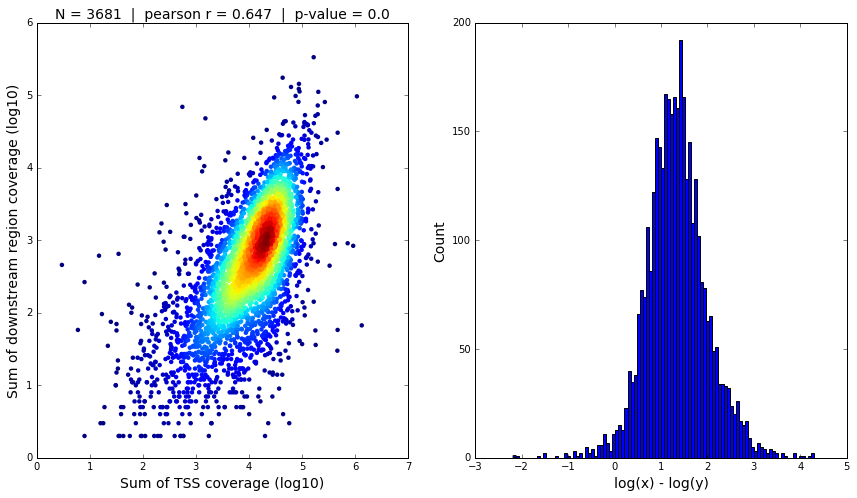

N =  3490
pearson r =  0.636
p-value =  0.0


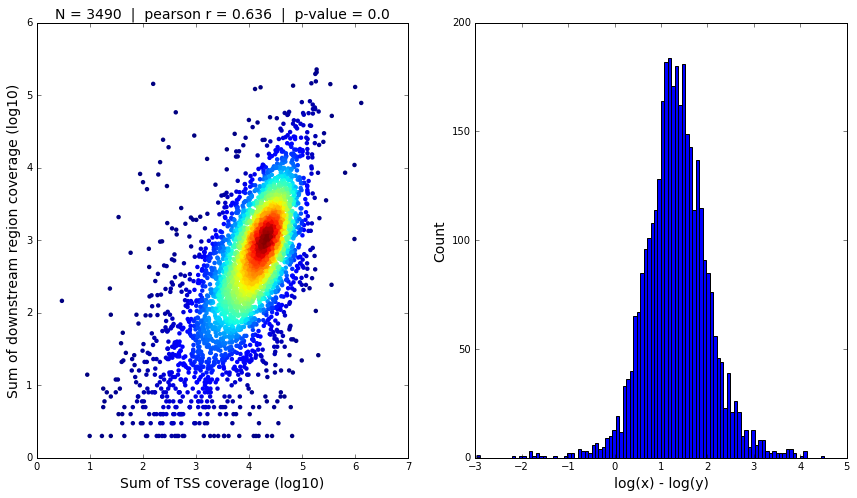

N =  7171
pearson r =  0.641
p-value =  0.0


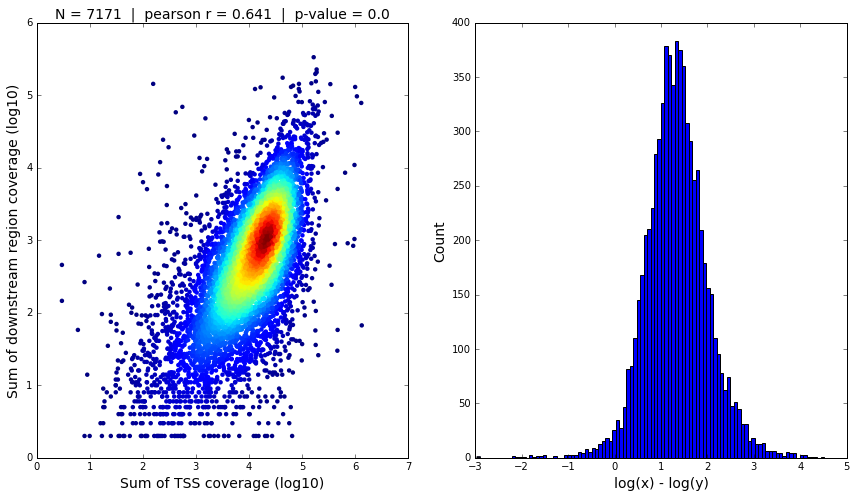

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [29]:
### This code calculates the coverage of a region around the TSS and a region downstream of the TSS, and 
### determines the correlation of coverage between the regions.

%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import os
from pybedtools import BedTool
import csv
import sys
import math
from scipy.stats import gaussian_kde

# Set this to True if you want to use coverage data from a previous run to make the graphs. This is useful
# if you have already run the script and just want to tweak the graphs. All that is needed is an input/output 
# directory and the 6 coverage bed files. 
# Set this to False if you want to calculate the windows and coverage again. Use this if you are running on a dataset
# for the first time, or need to recalculate the coverage. 
OLD = True

def main():  
       
    # Select the input and output directories
    INPUT_DIR = '/media/ab/data/Research_Data/GroSeqElongation/'
    OUTPUT_DIR = '/media/ab/data/Research_Data/GroSeqElongation/'
    if INPUT_DIR[-1] != '/':
        INPUT_DIR = INPUT_DIR + '/'
    if OUTPUT_DIR[-1] != '/':
        OUTPUT_DIR = OUTPUT_DIR + '/'
    print "Input directory is: ", INPUT_DIR
    print "Output directory is: ", OUTPUT_DIR
    
    # Enter the parameters to use
    TSS_WINDOW = 1000
    ELONGATION_DISTANCE = 10000
    MIN_GENE_LENGTH = TSS_WINDOW + ELONGATION_DISTANCE

    PARAM_NAME = '_'+TSS_WINDOW+'_'+ELONGATION_DISTANCE+'_'+MIN_GENE_LENGTH
    
    if OLD == False:

        # The bidirectionals should be a 3-column BED file with format: chr, start, stop 
        BIDIRECTIONALS = 'Allen2014_DMSO2_3-1_divergent_classifications.sample.bed'

        # The bidirectionals should be a 3-column BED file with format: chr, start, stop 
        COVERAGE_POS = 'DMSO2_3.pos.1M.BedGraph'
        COVERAGE_NEG = 'DMSO2_3.neg.1M.BedGraph'

        # The genes should be a 6-column BED file with format: chr, start, stop, name, N/A, strand
        GENES = 'hg19.refseqgenes.bed'

        # Make the windows that will be compared
        xWindowsBED, yWindowsBED = makeWindows(INPUT_DIR, GENES, TSS_WINDOW, 
                                               ELONGATION_DISTANCE, MIN_GENE_LENGTH, BIDIRECTIONALS)
        print 'Number of xWindows', len(xWindowsBED)
        print 'Number of yWindows', len(yWindowsBED)
        
        # Open the bedgraph files containing the coverage data
        coverageBEDPos = openBedGraph(INPUT_DIR, COVERAGE_POS)
        coverageBEDNeg = openBedGraph(INPUT_DIR, COVERAGE_NEG)

        # Calculate the coverage over the windows
        xPosCoverage = getCoverage(coverageBEDPos, filterBEDStrand(xWindowsBED, 5, "+"), 4)
        xNegCoverage = getCoverage(coverageBEDNeg, filterBEDStrand(xWindowsBED, 5, "-"), 4)
        yPosCoverage = getCoverage(coverageBEDPos, filterBEDStrand(yWindowsBED, 5, "+"), 4)
        yNegCoverage = getCoverage(coverageBEDNeg, filterBEDStrand(yWindowsBED, 5, "-"), 4)
        xCoverage = catBEDTool(xPosCoverage, xNegCoverage)
        yCoverage = catBEDTool(yPosCoverage, yNegCoverage)

        # Save the windows with coverage to bed files
        saveDataToText(OUTPUT_DIR, "xPosCoverage"+PARAM_NAME, xPosCoverage)
        saveDataToText(OUTPUT_DIR, "yPosCoverage"+PARAM_NAME, yPosCoverage)
        saveDataToText(OUTPUT_DIR, "xNegCoverage"+PARAM_NAME, xNegCoverage)
        saveDataToText(OUTPUT_DIR, "yNegCoverage"+PARAM_NAME, yNegCoverage)
        saveDataToText(OUTPUT_DIR, "xCoverage"+PARAM_NAME, xCoverage)
        saveDataToText(OUTPUT_DIR, "yCoverage"+PARAM_NAME, yCoverage)
        print len(xPosCoverage), len(yPosCoverage)
        print len(xNegCoverage), len(yNegCoverage)
        print len(xCoverage), len(yCoverage)


    else:
        # Load the coverage data from bed files
        xPosCoverage = ([ i.strip('\r\n').split('\t') for i in (openFile(INPUT_DIR, 'xPosCoverage'+PARAM_NAME+'.bed'))])
        yPosCoverage = ([ i.strip('\r\n').split('\t') for i in (openFile(INPUT_DIR, 'yPosCoverage'+PARAM_NAME+'.bed'))])
        print len(xPosCoverage), len(yPosCoverage)
        xNegCoverage = ([ i.strip('\r\n').split('\t') for i in (openFile(INPUT_DIR, 'xNegCoverage'+PARAM_NAME+'.bed'))])
        yNegCoverage = ([ i.strip('\r\n').split('\t') for i in (openFile(INPUT_DIR, 'yNegCoverage'+PARAM_NAME+'.bed'))])
        print len(xNegCoverage), len(yNegCoverage)
        xCoverage = ([ i.strip('\r\n').split('\t') for i in (openFile(INPUT_DIR, 'xCoverage'+PARAM_NAME+'.bed'))])
        yCoverage = ([ i.strip('\r\n').split('\t') for i in (openFile(INPUT_DIR, 'yCoverage'+PARAM_NAME+'.bed'))])
        print len(xCoverage), len(yCoverage)
    
    # Make the graphs of the coverage data
    makeGraphs(OUTPUT_DIR, 'Elongation_Correlation_Pos'+PARAM_NAME, singleColumn(xPosCoverage, 6), singleColumn(yPosCoverage, 6))
    makeGraphs(OUTPUT_DIR, 'Elongation_Correlation_Neg'+PARAM_NAME, singleColumn(xNegCoverage, 6), singleColumn(yNegCoverage, 6))
    makeGraphs(OUTPUT_DIR, 'Elongation_Correlation'+PARAM_NAME, singleColumn(xCoverage, 6), singleColumn(yCoverage, 6))

    ### End of function

def filterBEDStrand(data, column, strand):
    
    output = []
    for i in data:
        if i[column] == strand:
            output.append(i)
    return BedTool(output)

    ### End of function    

    
def catBEDTool(a, b):
    output = []
    for i in a:
        output.append(i)
    for i in b:
        output.append(i)
        
    return BedTool(output)

    ### End of function    

def singleColumn(data, column):
    
    out = []
    for i in data:
        out.append(int(i[column]))
    return out

    ### End of function    
    
def getCoverage(coverageBED, windowsBED, coverageSTRAND):
    
    coverage = windowsBED.map(coverageBED, c=coverageSTRAND, o='sum', null='0')
    return coverage
    
    ### End of function    

def openBedGraph(inputDir, coverageBEDFile):
    
    coverageBEDData = openFile(inputDir, coverageBEDFile)
    coverageBED = BedTool(coverageBEDData)
    coverageBED = coverageBED.sort()
    coverageBED = [i for i in coverageBED]
    return coverageBED
    
    ### End of function    
    
def makeWindows(input_dir, geneFile, tssWindow, elongationDistance, minGeneLength, bidirFile):
    
    geneData = openFile(input_dir, geneFile)
    bidirData = openFile(input_dir, bidirFile)
    geneData = [i for i in geneData]
    print "Number of input intervals: ", len(geneData)
    bidirData = [i for i in bidirData]
    print "Number of bidirectionals: ", len(bidirData)
    bidirBED = BedTool(bidirData).sort()
    mergedGenesBED = BedTool(geneData).sort().merge(s=True)
    print "Number of genes after merge: ", len(mergedGenesBED)
    xWindows = []
    plus = 0
    minus = 0
    name=0
    for line in mergedGenesBED:
        #print line
        chromosome = str(line[0])
        start = line[1]
        end = line[2]
        strand = str(line[3])
        newX = ['', '', '', '', '', '']
        if ((int(end)-int(start)) >= minGeneLength):
            newX[0] = chromosome
            newX[3] = name
            newX[4] = 0
            newX[5] = strand
            if strand == '+':
                newX[1] = int(start) - int(tssWindow)  
                newX[2] = int(start) + int(tssWindow)
                plus += 1
            elif strand == '-':
                newX[1] = int(end) - int(tssWindow)  
                newX[2] = int(end) + int(tssWindow)          
                minus += 1
            xWindows.append(newX)
            name += 1
    xWindowsBED = BedTool(xWindows)
    xWindows = xWindowsBED.intersect(bidirBED, u=True)
    yWindows = []
    print "x values: ", plus, minus
    plus = 0
    minus = 0
    for i in xWindows:
        newY = ['', '', '', '','', '']
        newY[0] = i[0]
        newY[3] = i[3]
        newY[4] = i[4]
        newY[5] = i[5]
        if i[5] == '+':
            newY[1] = int(i[1]) + int(elongationDistance) 
            newY[2] = int(i[2]) + int(elongationDistance)
            plus += 1
        else:
            newY[1] = int(i[1]) - int(elongationDistance) 
            newY[2] = int(i[2]) - int(elongationDistance)           
            minus +=1
        yWindows.append(newY)
    xWindowsBED = BedTool(xWindows).sort()
    yWindowsBED = BedTool(yWindows).sort()
    print  "y values: ", plus, minus
    print len(xWindowsBED), len(yWindowsBED)
    return xWindowsBED, yWindowsBED
   
    ### End of function

def openFile(inputDirectory, fileName):
        
    data = open(inputDirectory + fileName)
    return data
   
    ### End of function

def makeGraphs(outputDir, name ,x, y):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
    
    x,y = [math.log(i,10) for i,j in zip(x,y) if i > 1 and j > 1],[math.log(j,10) for i,j in zip(x,y) if i>1 and j > 1 ]

    
    pearsonr = stats.pearsonr(x, y)

    print 'N = ', len(x)
    print 'pearson r = ', round(pearsonr[0],3)
    print 'p-value = ', pearsonr[1]
    
    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    ax1.scatter(x,y, c=z, edgecolor='')
    ax1.set_title(str('N = '+str(len(x))+'  |  '+'pearson r = '+str(round(pearsonr[0],3))), size=14)
    #ax1.set_xscale("log", subsx=None)
    #ax1.set_yscale("log", subsx=None)
    ax1.set_xlim(0, 7)
    ax1.set_ylim(0, 7)
    ax1.set_xlabel('Sum of TSS coverage (log10)', size=14)
    ax1.set_ylabel('Sum of downstream region coverage (log10)', size=14)
    

    z = []
    for i in range(len(x)):
        if x[i] > 0:
            z.append(x[i]-y[i])
    #print max(z)
    #ax2.hist(z, 100, normed=0, range=(0, 1))
    ax2.hist(z, 100, normed=0)

    ax2.set_xlabel('log(x) - log(y)', size=14)
    ax2.set_ylabel('Count', size=14)
    plt.tight_layout()
    plt.savefig(outputDir+name+'.svg',format='svg')
    plt.savefig(outputDir+name+'.png',format='png')
    plt.show()

    ### End of function
                  
def load_beds(inputDirectory, fileName):
    
    bed_list = []
    for i in intervals:
        bed_list.append((i,BedTool(directory+i).sort()))
    print 
    return bed_list

    ### End of function

def saveDataToText(directory, name, data):

    # Save the line data to an output text file in the same directory as the graphs

    # Create writer
    ofile  = open(directory+name+'.bed', "wb")
    writer = csv.writer(ofile, delimiter='\t')
    
    # Write each line
    for line in data:
        outLine = []
        for i in line:
            outLine.append(i)
        writer.writerow(outLine)

    # Close the file
    ofile.close()
    return            
    ### End of function


if __name__ == "__main__":
    sys.exit(main())

In [ ]:
xWindows = []
yWindows = []
print xWindows
xWindows.append('test1')
print xWindows
print yWindows

In [16]:
x = open('/media/ab/data/Research_Data/GroSeqElongation/'+'Allen2014_DMSO2_3-1_divergent_classifications.sample.bed')
print BedTool(x)

chr1	28978	29625	ME_2593|29301.941155,194.754116,128.728526,0.231616,250.000000,0.632146,0.000051,0.367748,30781.000000,27829.000000
chr1	441891	442115	ME_1021|442003.585345,26.616501,85.406087,0.623234,20.015689,0.888412,0.110896,0.000194,443281.000000,440689.000000
chr1	539416	542086	ME_190|540751.577171,1304.756950,30.622790,0.492545,95.161828,0.143408,0.539624,0.316191,542071.000000,539479.000000
chr1	713949	714264	ME_2771|714106.645407,15.358128,142.045002,0.331374,111.740590,0.936344,0.000013,0.063614,715501.000000,712834.000000
chr1	737257	739713	ME_2664|738485.244562,1100.333204,127.539455,0.501790,250.000000,0.151238,0.650628,0.190286,739801.000000,737449.000000
chr1	748391	748860	ME_348|748626.002149,74.519834,159.988546,0.311627,191.118603,0.972519,0.005565,0.005757,749671.000000,747349.000000
chr1	762762	763095	ME_346|762928.979357,16.254216,150.656536,0.872484,97.413891,0.810291,0.012958,0.176666,764176.000000,761269.000000
chr1	839584	840512	ME_3010|840048.072661,227.7992

In [82]:
import  pybedtools
a = pybedtools.example_bedtool("a.bed")
b = pybedtools.example_bedtool("b.bed")
print a
print b
d = a.cat(b, postmerge=False).sort()
print d
#c = pybedtools.BedTool("", from_string=True)
#print(a.cat(c))

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	900	950	feature4	0	+

chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+
chr1	900	950	feature4	0	+



In [4]:
x = ['d', 'h', 'e', 'a']
for i in range(len(x)):
    print x[i]

d
h
e
a


In [3]:
x = 3.71
print int(x)

3
